In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import evaluation
import pickle

ROOT_PATH = '/home/jhladnik/'


In [48]:

def visualise_model_param_eval(df_news, df_tweets, param_name, suffix=""):
    # Create a figure with 2 columns and 3 rows
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))
    palette = ["k", "r", "b", "y", ]
    hue_order = [ 'BERTopic', 'top2vec',  "NMF", 'LDA',]

    # Plot data1 in the first column
    if df_news is not None:
        sns.lineplot(data=df_news, x=param_name, y='topic_diversity', hue="model_name", ax=axs[0][0], palette=palette, hue_order=hue_order)
        sns.lineplot(data=df_news, x=param_name, y='topic_coherence_npmi', hue="model_name", ax=axs[1][0], palette=palette, hue_order=hue_order)
        #sns.lineplot(data=df_news, x=param_name, y='topic_coherence_umass', hue="model_name", ax=axs[2][0], palette=palette, hue_order=hue_order)

    # Plot data2 in the second column
    if df_tweets is not None:
        sns.lineplot(data=df_tweets, x=param_name, y='topic_diversity', hue="model_name", ax=axs[0][1], palette=palette, hue_order=hue_order)
        sns.lineplot(data=df_tweets, x=param_name, y='topic_coherence_npmi', hue="model_name", ax=axs[1][1], palette=palette,  hue_order=hue_order)
        #sns.lineplot(data=df_tweets, x=param_name, y='topic_coherence_umass', hue="model_name", ax=axs[2][1], palette=palette, hue_order=hue_order)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
    pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
    plt.show()



# QUANTITATIVE EVALUATION
The default parameters that we use (unless specified otherwise):
- num_documents = 50 000
- num top-n_words = 10
- num topics = 15
- year of documents: 2020

Save plots as both image and object (for possible later changes)

## Number of documents
also showing variance of results and show how much documents we need for the rest of evaluation

### different docs and different seeds

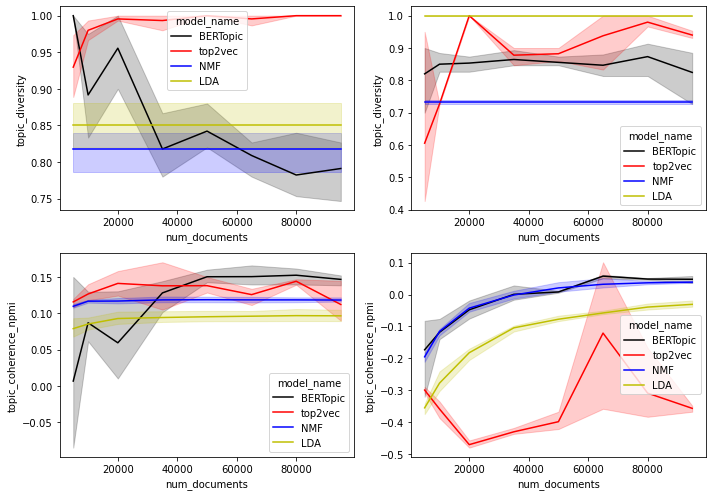

In [49]:
NUM_SAMPLES = 300_000
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_news_{NUM_SAMPLES}_sampled_docs.csv")
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_tweets_{NUM_SAMPLES}_sampled_docs.csv")
visualise_model_param_eval(df_news, df_tweets, param_name="num_documents", suffix="_diff_docs")

### only different seeds, same documents

KeyboardInterrupt: 

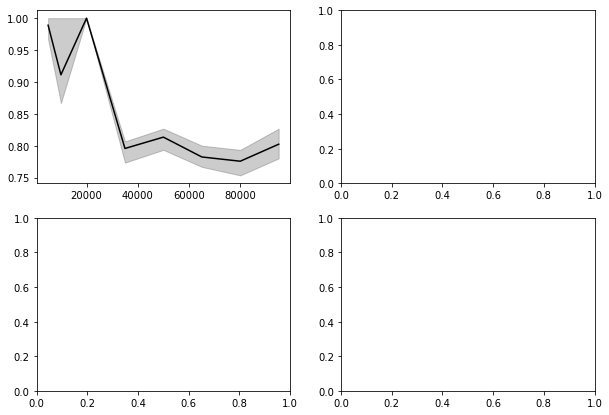

In [50]:
NUM_SAMPLES = 300_000
ROOT_PATH = '/home/jhladnik/'
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_news_{NUM_SAMPLES}.csv")
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_tweets_{NUM_SAMPLES}.csv")
visualise_model_param_eval(df_news, df_tweets, param_name="num_documents", suffix="_same_docs")

## Number of top-k words

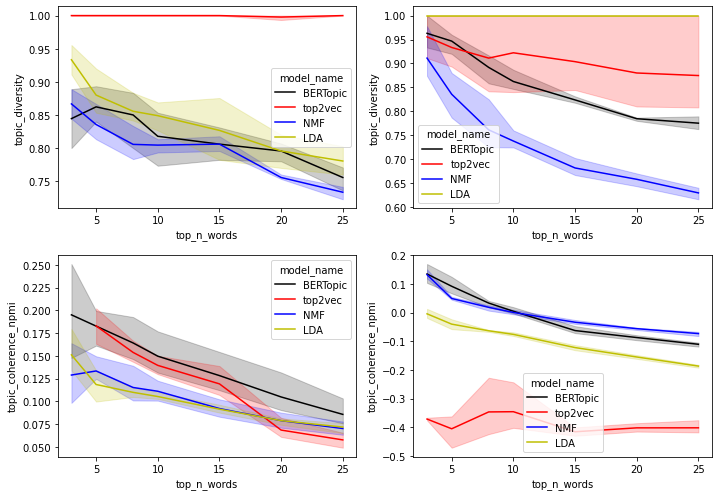

In [ ]:
num_samples = 50000
year = 2020
ROOT_PATH = '/home/jhladnik/'
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/top_n_words_models_{dataset}_{num_samples}_{year}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/top_n_words_models_{dataset}_{num_samples}_{year}.csv")
visualise_model_param_eval(df_news, df_tweets, param_name="top_n_words")

## Number of topics

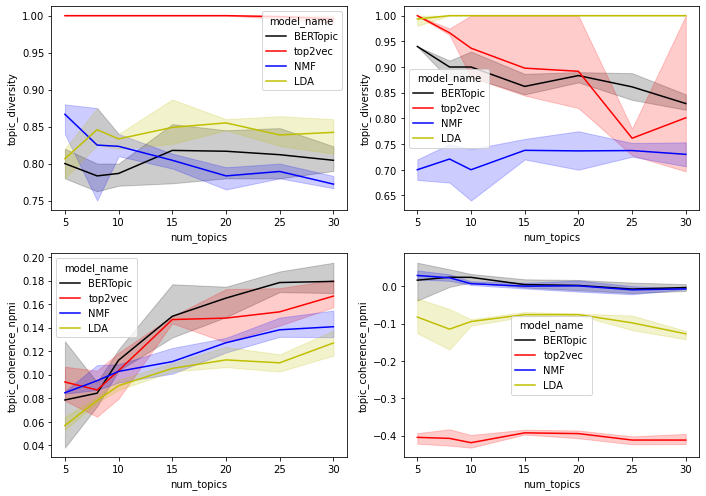

In [ ]:
num_samples = 50000
year = 2020
ROOT_PATH = '/home/jhladnik/'
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
visualise_model_param_eval(df_news, df_tweets, param_name="num_topics")

# QUALITATIVE EVALUATION
Here we just display words for certain parameters for topic models

In [ ]:
from evaluation import jaccard_index,  get_word2vec_embedding, get_fasttext_embedding, get_maximum_word_matching, get_maximum_topic_matching, cosine_similarity
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

slo_wv_path = "/home/jhladnik/masters-thesis/word2vec/model.bin"

wv_from_bin = KeyedVectors.load_word2vec_format(slo_wv_path, binary=True)  # C bin format
word2vec_model = wv_from_bin

In [ ]:
num_samples = 50000
year = 2020
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")

In [ ]:
from evaluation import get_models_topic_words


def display_topics(df):
    models_topics = {}

    model_name = "BERTopic"
    for model_name in ["BERTopic", "top2vec", "LDA", "NMF", ]:
        topics = get_models_topic_words(df, model_name=model_name, param_name="num_topics", param_value=10, seed=1, verbose=False)

        models_topics[model_name] = topics

    return pd.DataFrame(models_topics)

#df_default = display_topics(df_news)
#df_default.to_csv("topic_representations.csv")

In [ ]:
def model_topics_w_matching_merged(df, param_name, param_value, seed):
    models_topics = {}

    bertopics = get_models_topic_words(df, model_name="BERTopic", param_name=param_name, param_value=param_value, seed=seed, verbose=False)
    bertopics = [tuple(x) for x in bertopics]
    df_out = pd.DataFrame({"BERTopic":bertopics})

    for model_name in [ "top2vec", "LDA", "NMF", ]:
        topics = get_models_topic_words(df, model_name=model_name, param_name=param_name, param_value=param_value, seed=seed, verbose=False)

        bertopic_matching_dict = {f"BERTopic": [], model_name: [], f"BERTopic_{model_name}_score": []}
        pairs, score = get_maximum_topic_matching(bertopics, topics, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)

        for pair in pairs:
            bertopic_matching_dict[f"BERTopic"].append(tuple(pair[0]))
            bertopic_matching_dict[model_name].append(tuple(pair[1]))
            bertopic_matching_dict[f"BERTopic_{model_name}_score"].append(pair[2])

        df_matching = pd.DataFrame(bertopic_matching_dict)

        df_out = df_out.merge(df_matching, on="BERTopic", how="outer")

        

        models_topics[model_name] = topics
    return df_out

#df_default = model_topics_w_matching_merged(df_tweets, "num_topics", 10, 1)
#df_default

BERTopic  \
0  (imeti, slovenija, vlada, iti, slovenski, člov...   
1  (koronavirus, okužba, nov, italija, okužen, sl...   
2  (zdravnik, zdravstven, zdravstvo, dr, zdravje,...   
3  (sodišče, sodnik, ustaven, pravnik, tožilstvo,...   
4  (protest, protestnik, smrt, protestirati, petk...   
5  (tekma, šport, zmaga, prvak, olimpija, liga, š...   
6  (maska, zaščiten, nositi, oprema, nošenje, ime...   
7  (otrok, zastava, starš, družina, mama, mati, o...   
8  (komunist, komunističen, komunizem, imeti, nar...   
9  (vlada, tehničen, pomoč, oseba, gasilec, prija...   

                                             top2vec  BERTopic_top2vec_score  \
0  (zakonodaja, nasvet, spregledati, preziveti, p...                0.470378   
1  (beovic, cca, dvakrat, postajati, zacetek, mil...                0.321270   
2  (zgaga, unicevati, bozicen, masa, nebo, ustava...                0.244831   
3  (spomenka, ogrozati, vreci, dnevno, slucajno, ...                0.370606   
4  (pogasiti, eksplozija, prihod, pgd, vozilo, ne...                0.450608   
5  (strokovnjak, dosti, neumnost, prebivalstvo, d...                0.387656   
6  (zacetek, ogrozati, presernov, revizija, kos, ...                0.350381   
7  (spodaj, matej, alenka, generacija, nacelo, po...                0.404261   
8  (rast, negativen, posel, dvakrat, napacen, spr...                0.397558   
9  (negativen, svetovati, napacen, dnevno, zaupan...                0.423585   

                                                 LDA  BERTopic_LDA_score  \
0  (imeti, Slovenija, vlada, iti, slovenski, člov...            0.738367   
1  (nov, covid, ukrep, svet, epidemija, koronavir...            0.610730   
2  (minister, zdravje, vladen, poziv, sprememba, ...            0.381629   
3  (državen, evropski, sodišče, občina, narod, os...            0.529551   
4  (potrebovati, zgoditi, pot, znati, naslednji, ...            0.449060   
5  (prebrati, zmaga, knjiga, Janšev, odgovor, pre...            0.363834   
6  (maska, hvala, via, živeti, zveza, hiša, oprem...            0.563028   
7  (otrok, star, življenje, šola, dom, mlad, novi...            0.536924   
8  (država, delati, dobiti, priti, videti, konec,...            0.485401   
9  (delo, pomoč, pravica, koalicija, laž, tehniče...            0.543167   

                                                 NMF  BERTopic_NMF_score  
0  (iti, RTV, priti, reči, spati, denar, dati, mi...            0.477180  
1  (nov, okužba, koronavirus, mesto, covid, Ljubl...            0.527990  
2  (čas, covid, epidemija, minister, delo, korona...            0.376771  
3  (slovenski, vojska, narod, medij, politika, Sl...            0.436589  
4  (vedeti, ukrep, Janša, stranka, medij, ministe...            0.377634  
5  (Slovenija, RTV, republika, svet, koronavirus,...            0.341718  
6  (človek, delati, maska, umreti, življenje, vid...            0.547708  
7  (imeti, pravica, težava, zato, delati, pojem, ...            0.454894  
8  (država, globok, praven, predsednik, svet, evr...            0.529969  
9  (vlada, predsednik, Janšev, lev, prejšnji, min...            0.307035

## display latex

In [ ]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000

#df_default = df_default.melt(var_name="model_name", value_name="topic_words")

### default

In [ ]:
num_samples = 50000
year = 2020
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")

In [ ]:
df_disp = model_topics_w_matching_merged(df_news, "num_topics", 15, 1)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
#print(df_disp.to_latex())
df_disp

BERTopic  \
0                         (imeti, nov, slovenija, čas, država, slovenski, človek, delo, vlada, ukrep)   
1                          (tekma, točka, sezona, zmaga, liga, minuta, ekipa, mesto, igralec, turnir)   
2                 (občina, stanovanje, objekt, prostor, požar, gradnja, projekt, odpadek, nov, cesta)   
3              (okužba, nov, koronavirus, kitajski, država, človek, število, potrditi, umreti, virus)   
4                (film, filmski, imeti, življenje, igralec, meghan, družina, vloga, režiser, igralka)   
5              (okužba, nov, dom, cepivo, covid, okužen, bolnik, stanovalec, koronavirus, bolnišnica)   
6            (stranka, vlada, desus, predsednik, koalicija, poslanec, volitev, smc, janša, poslanski)   
7                       (slovenija, ukrep, vlada, meja, država, odlok, hrvaški, trgovina, nov, javen)   
8               (trump, biden, zda, ameriški, predsednik, volitev, trumpov, donald, država, demokrat)   
9                (vozilo, cesta, nesreča, voznik, prometen, avtocesta, policist, ura, promet, prehod)   
10                   (dirka, etapa, kolesar, roglič, pogačar, tour, zmaga, ekipa, majica, kolesarski)   
11                     (ljubezen, življenje, imeti, partner, odnos, otrok, zato, čas, služba, človek)   
12                       (odstotek, indeks, evro, cena, rast, nafta, dolar, odstoten, borza, delnica)   
13         (glasba, glasben, koncert, pesem, album, skladba, festival, glasbenik, slovenski, skupina)   
14  (piškotek, uporabnik, telefon, spleten, pameten, huawei, naprava, aplikacija, omogočati, mobilen)   

                                                                                                               top2vec  \
0                         (posvariti, bruselj, tiskoven, kanclerka, fonet, parlament, unija, premier, borrell, oblast)   
1                      (koncnica, kosarkar, clippers, dvoboj, soigralec, priigrati, ljubljancan, podaja, poraz, tekma)   
2         (kanalizacijski, vgradnja, gradnja, gradben, novogradnja, izgradnja, razsvetljava, eko, toploten, vodovoden)   
3           (policist, kazniv, osumljenec, osumljen, povzrocitev, pridrzati, oskodovanec, prostost, dejanje, storilec)   
4                  (nogometas, vezist, zabiti, zadetek, nogometen, prvoligas, branilec, enajstmetrovka, derbi, vratar)   
5   (bolnik, bolnisnicen, pacient, obolenje, obolel, hospitaliziran, infekcijski, prebolevati, dihalo, infektologinja)   
6                                        (smc, desus, poslanski, lms, koalicija, sds, koalicijski, poslanec, nsi, sab)   
7            (odlok, razkuzevanje, nijz, prehajanje, omejitev, izjema, ponujanje, upostevanje, obratovanje, higienski)   
8                 (demokrat, republikanski, trump, republikanec, trumpov, biden, demokratski, donald, bidnov, clinton)   
9                        (padavina, vremenoslovec, veter, jugozahodnik, vremenski, nizina, burja, nevihta, dez, naliv)   
10                              (stopnicka, dirka, karavana, kronometer, etapen, tour, sprint, start, dirkati, roglic)   
11             (obozevalec, pevka, seksi, zaljubiti, obozevalka, obozevati, ljubezenski, zaljubljen, zmenek, postaven)   
12               (obresten, likvidnost, bruto, makroekonomski, rast, kreditiranje, medletno, prihodek, bdp, potrosnja)   
13                  (literaren, opus, gledaliski, umetniski, pisatelj, dramski, umetnost, umetnik, razstava, pripoved)   
14              (vmesnik, pameten, android, digitalen, googlov, windows, tehnologija, platforma, omrezen, operacijski)   

                                                                                             LDA  \
0             (izdelek, sistem, nov, imeti, hrana, model, razvoj, uporaba, električen, različen)   
1                  (tekma, liga, klub, sezona, točka, minuta, igrati, igralec, ekipa, nogometen)   
2                    (občina, delo, šola, dom, otrok, javen, Ljubljana, zaposlen, center, zavod)   
3    (policija, evropski, sodišče, država, policist, dejanj

In [ ]:
df_disp = model_topics_w_matching_merged(df_tweets, "num_topics", 15, 1)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
#print(df_disp.to_latex())
df_disp

BERTopic  \
0                                 (imeti, slovenija, vlada, iti, človek, nov, čas, slovenski, država, vedeti)   
1                  (koronavirus, okužba, italija, nov, okužen, slovenija, test, epidemija, testiranje, covid)   
2              (zdravnik, zdravstven, zdravstvo, dr, zdravje, bolnišnica, bolnik, medicinski, pacient, covid)   
3                     (sodišče, sodnik, ustaven, pravnik, tožilstvo, sodnica, sodstvo, sodba, vrhoven, zapor)   
4               (protest, protestnik, smrt, protestirati, petkov, ljubljana, grožnja, novica, janšizem, umor)   
5                        (tekma, šport, zmaga, prvak, olimpija, liga, športen, prvenstvo, nogomet, slovenski)   
6                              (maska, zaščiten, nositi, oprema, nošenje, imeti, nos, obraz, človek, obvezen)   
7                                  (otrok, zastava, starš, družina, mama, mati, oče, imeti, mlad, vzgojitelj)   
8      (komunist, komunističen, komunizem, narod, totalitarizem, imeti, slovenec, človek, partija, naslednik)   
9                     (vlada, tehničen, pomoč, oseba, gasilec, prijava, reševalec, obolel, helikopter, vrata)   
10                   (ljubljana, slovenija, slovenec, slovenski, stanovanje, kranj, ulica, imeti, janez, čas)   
11            (policija, policist, policijski, sindikat, policaj, slovenski, minister, ura, slovenija, imeti)   
12  (volitev, demokracija, volilen, glas, slovenski, slovenija, stranka, glasovati, demokratičen, belorusija)   
13              (minister, ministrica, notranji, zunanji, premier, vlada, ministrstvo, sekretar, obisk, delo)   
14                               (evro, milijon, proračun, eur, milijarda, denar, kredit, banka, mio, dobiti)   

                                                                                                           top2vec  \
0                     (tovaris, igralec, firma, navodilo, mariborski, ustanova, edino, doseci, preteklost, rtvslo)   
1                           (kam, spati, delez, uporabiti, coronavirus, puska, sodelovati, nebo, dvakrat, iranski)   
2                  (izgledati, motiti, zivec, strokovnjak, kupovati, tocka, zaposlitev, vplivati, vladen, skusati)   
3                      (droga, nauciti, poteza, vrhunski, dnevno, negativen, domoljub, skupnost, vrhoven, vladati)   
4                          (ubiti, umrl, polovica, posten, jesti, spominjati, rtvslo, beovic, korupcija, ukrepati)   
5                                  (zaliti, majica, ponoviti, navodilo, zbor, igralec, top, naloziti, jasa, prvak)   
6                           (spomniti, merilo, kritizirati, nehati, jopic, fasizem, odlicno, sram, spodaj, branje)   
7                                 (prenasati, zgaga, rezerva, veja, spati, dvakrat, srecati, vest, rumen, praznik)   
8                       (obsoditi, teroristicen, narociti, bitka, noc, izgledati, jajce, desetletje, tvit, motiti)   
9                              (eksplozija, prevoz, pozar, gasilec, prihod, vikend, voznja, preprost, kamera, pgd)   
10                      (eksplozija, gasilec, pgd, pozar, odpeljati, brezplacen, voznik, sarcev, cesta, resevalec)   
11                            (izgledati, prof, programski, udba, prodati, matjaz, corrupt, galet, strosek, ubiti)   
12  (slovenscina, stalisce, balkanski, trump, posameznik, obnasati, davkoplacevalec, peticija, neumen, ideologija)   
13                        (kolumna, galet, ustanova, sram, posel, zidan, razkritje, korupcija, pocitnice, odlicno)   
14                    (nauciti, uspesen, dnevno, vrhunski, uciti, ukvarjati, okrevanje, trend, nasvet, desetletje)   

                                                                                               LDA  \
0                  (človek, vedeti, Janša, delati, dati, videti, povedati, začeti, Janez, volitev)   
1                    (imeti, Slovenija, nov, čas, covid, ukrep, zato, epidemija, dr., koronavirus)   
2                 (zdravstven, ZDA, doma, gasilec, požar, oprema, ulica, zaščiten, začetek, letos

### 10 topics

In [ ]:
num_samples = 50000
year = 2020
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")

In [ ]:
df_disp = model_topics_w_matching_merged(df_news, "num_topics", 10, 1)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
#print(df_default.to_latex())
df_disp

BERTopic  \
0                             (imeti, slovenija, vlada, iti, slovenski, človek, nov, čas, država, vedeti)   
1              (koronavirus, okužba, nov, italija, okužen, slovenija, test, epidemija, testiranje, covid)   
2          (zdravnik, zdravstven, zdravstvo, dr, zdravje, bolnišnica, bolnik, medicinski, covid, pacient)   
3                 (sodišče, sodnik, ustaven, pravnik, tožilstvo, sodnica, sodstvo, sodba, vrhoven, zapor)   
4           (protest, protestnik, smrt, protestirati, petkov, ljubljana, grožnja, novica, janšizem, umor)   
5                    (tekma, šport, zmaga, prvak, olimpija, liga, športen, prvenstvo, nogomet, slovenski)   
6                          (maska, zaščiten, nositi, oprema, nošenje, imeti, človek, nos, obraz, obvezen)   
7                              (otrok, zastava, starš, družina, mama, mati, oče, imeti, mlad, vzgojitelj)   
8  (komunist, komunističen, komunizem, imeti, narod, totalitarizem, slovenec, človek, partija, naslednik)   
9                 (vlada, tehničen, pomoč, oseba, gasilec, prijava, reševalec, imeti, obolel, helikopter)   

                                                                                              top2vec  \
0   (zakonodaja, nasvet, spregledati, preziveti, prebivalstvo, zacetek, domov, desus, pozivati, rast)   
1              (beovic, cca, dvakrat, postajati, zacetek, milan, faktor, polovica, obvestilo, posten)   
2                (zgaga, unicevati, bozicen, masa, nebo, ustava, storitev, zacasen, placevati, moder)   
3               (spomenka, ogrozati, vreci, dnevno, slucajno, tomic, jasa, navodilo, nemogoc, letnik)   
4              (pogasiti, eksplozija, prihod, pgd, vozilo, nesreca, prometen, pozar, smer, odpeljati)   
5         (strokovnjak, dosti, neumnost, prebivalstvo, dunaj, ubiti, zlatko, gobec, primorski, morje)   
6  (zacetek, ogrozati, presernov, revizija, kos, spominjati, obvestilo, ozadje, bistveno, telefonski)   
7                   (spodaj, matej, alenka, generacija, nacelo, poklic, aja, kolumna, dusa, ponuditi)   
8                (rast, negativen, posel, dvakrat, napacen, spregledati, izziv, sum, uciti, zaupanje)   
9        (negativen, svetovati, napacen, dnevno, zaupanje, mojca, intenziven, hribar, pameten, nacrt)   

                                                                                          LDA  \
0           (imeti, Slovenija, vlada, iti, slovenski, človek, čas, vedeti, predsednik, Janša)   
1              (nov, covid, ukrep, svet, epidemija, koronavirus, mesto, zakon, okužba, virus)   
2  (minister, zdravje, vladen, poziv, sprememba, zunanji, sramota, preiskava, varnost, sklad)   
3  (državen, evropski, sodišče, občina, narod, oseba, ustaven, zdravstvo, kultura, podpirati)   
4     (potrebovati, zgoditi, pot, znati, naslednji, cesta, nesreča, spleten, oseben, plačati)   
5      (prebrati, zmaga, knjiga, Janšev, odgovor, prejeti, vodja, nemški, cerkev, upokojenec)   
6              (maska, hvala, via, živeti, zveza, hiša, oprema, zaščiten, poslušati, poslati)   
7                  (otrok, star, življenje, šola, dom, mlad, novica, umreti, mogoč, pozabiti)   
8             (država, delati, dobiti, priti, videti, konec, misliti, vojna, pisati, levičar)   
9          (delo, pomoč, pravica, koalicija, laž, tehničen, ženska, čestitka, iskati, zadeva)   

                                                                                                 NMF  
0                                  (iti, RTV, priti, reči, spati, denar, dati, minister, Rtv, maska)  
1            (nov, okužba, koronavirus, mesto, covid, Ljubljana, demokracija, okužen, gasilec, star)  
2                     (čas, covid, epidemija, minister, delo, koronavirus, večen, dr., virus, kriza)  
3              (slovenski, vojska, narod, medij, politika, Slovenec, državen, meja, policija, javen)  
4                    (vedeti, ukrep, Janša, stranka, medij, minister, političen, maska, Janez, svet)  
5  (Slovenija, RTV, republika, svet, koronavirus, preds

In [ ]:
df_default = model_topics_w_matching_merged(df_tweets, "num_topics", 10, 1)
df_default = df_default[["BERTopic", "top2vec", "LDA", "NMF"]]
print(df_default.to_latex())

\begin{tabular}{lllll}
\toprule
{} &                                                                                  BERTopic &                                                                                                           top2vec &                                                                                                 LDA &                                                                                            NMF \\
\midrule
0 &               (imeti, nov, slovenija, čas, človek, slovenski, država, delo, vlada, ukrep) &       (obozevalec, pevka, zaljubiti, obozevalka, seksi, ljubezenski, romanticen, postaven, zaljubljen, instagram) &                             (imeti, čas, človek, zato, življenje, iti, otrok, vedeti, svet, videti) &                  (nov, podjetje, delo, čas, slovenski, projekt, spleten, svet, zato, področje) \\
1 &                 (tekma, točka, sezona, zmaga, liga, minuta, mesto, ekipa, igralec, imeti) &                           (zadetek, so

### 5 topics

In [ ]:
num_samples = 50000
year = 2020
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")

In [ ]:
df_disp = model_topics_w_matching_merged(df_news, "num_topics", 5, 1)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
#print(df_disp.to_latex())
df_disp

BERTopic  \
0            (imeti, nov, slovenija, čas, država, človek, slovenski, vlada, delo, ukrep)   
1      (tekma, klub, liga, sezona, nogometen, prvenstvo, prvak, nogometaš, imeti, ekipa)   
2              (tekma, točka, sezona, zmaga, liga, minuta, mesto, ekipa, imeti, igralec)   
3       (občina, stanovanje, objekt, prostor, nov, projekt, požar, gradnja, delo, cesta)   
4  (film, imeti, filmski, življenje, igralec, družina, vloga, meghan, festival, režiser)   

                                                                                                                            top2vec  \
0                (demokraticen, politicen, demokracija, opozicija, jansev, koalicija, jansa, koalicijski, ideoloski, parlamentaren)   
1                                 (branilec, tekma, kapetan, soigralec, trener, zadetek, derbi, reprezentancen, reprezentant, dres)   
2                                  (okuzba, bolnik, obolel, covid, bolnisnicen, okuzen, hospitaliziran, sirjenje, beovicev, dihalo)   
3  (obresten, depozit, dobickonosnost, donosnost, portfelj, likvidnost, digitalizacija, makroekonomski, kreditiranje, investiranje)   
4                          (romanticen, ljubezenski, obozevalka, pevka, ljubiteljica, seksi, pesem, videospot, ljubimec, zaljubiti)   

                                                                                           LDA  \
0  (Slovenija, vlada, država, evro, predsednik, odstotek, delo, slovenski, evropski, podjetje)   
1         (nov, okužba, koronavirus, država, človek, ukrep, covid, število, zdravstven, imeti)   
2                    (tekma, sezona, liga, ekipa, klub, imeti, mesto, zmaga, slovenski, točka)   
3                (občina, nov, vozilo, ura, policist, imeti, cesta, spleten, prostor, območje)   
4                      (imeti, čas, človek, življenje, otrok, iti, zato, svet, nov, slovenski)   

                                                                                               NMF  
0              (nov, okužba, koronavirus, država, človek, število, covid, potrditi, ukrep, okužen)  
1  (Slovenija, slovenski, vlada, država, Ljubljana, predsednik, evropski, evro, minister, stranka)  
2                       (tekma, sezona, liga, ekipa, imeti, klub, mesto, slovenski, točka, igrati)  
3                           (občina, ukrep, javen, delo, ura, čas, mesten, dom, epidemija, center)  
4                         (imeti, človek, čas, iti, otrok, zato, življenje, vedeti, priti, videti)

In [ ]:
df_disp = model_topics_w_matching_merged(df_tweets, "num_topics", 5, 1)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
#print(df_disp.to_latex())
df_disp

BERTopic  \
0                     (imeti, vlada, slovenija, iti, slovenski, človek, nov, država, čas, vedeti)   
1      (koronavirus, okužba, nov, italija, okužen, slovenija, epidemija, test, testiranje, covid)   
2  (zdravnik, zdravstven, zdravstvo, dr, zdravje, bolnišnica, bolnik, covid, medicinski, pacient)   
3         (sodišče, sodnik, ustaven, pravnik, tožilstvo, sodnica, sodstvo, sodba, vrhoven, zapor)   
4   (protest, protestnik, smrt, protestirati, petkov, ljubljana, grožnja, novica, janšizem, umor)   

                                                                                        top2vec  \
0  (srecati, lastnik, upanje, spregledati, skoda, opraviciti, cca, prenasati, kongres, pogovor)   
1  (odlicno, obramben, kupovati, plebiscit, alenka, balkanski, dvigniti, cepivo, jopic, potres)   
2             (aja, poraz, zgaga, nor, veselje, krsiti, kolesariti, teroristicen, moder, vreme)   
3    (najprej, preziveti, firma, opozorilo, nemski, polovica, milan, udba, policaj, ponavljati)   
4     (zjutraj, spustiti, resevalec, izpad, odpeljati, dneven, voznja, polozaj, pozar, gasilec)   

                                                                                              LDA  \
0                            (imeti, iti, človek, država, čas, vedeti, covid, ukrep, svet, maska)   
1  (Slovenija, nov, slovenski, predsednik, dr., Slovenec, koronavirus, mesto, evropski, politika)   
2                 (Ljubljana, pomoč, policija, ura, sodišče, meja, oddaja, vojna, občina, beseda)   
3              (vlada, minister, Janša, medij, javen, stranka, političen, državen, RTV, poslanec)   
4                  (pravica, služba, koalicija, direktor, član, slišati, ime, laž, vesel, ženska)   

                                                                                              NMF  
0                    (imeti, vedeti, država, pravica, težava, delati, zato, povedati, čas, maska)  
1           (nov, čas, covid, ukrep, slovenski, okužba, koronavirus, minister, država, epidemija)  
2  (Slovenija, država, RTV, slovenski, republika, predsednik, svet, Janša, koronavirus, evropski)  
3            (vlada, predsednik, slovenski, Janša, Janez, minister, lev, Janšev, ukrep, prejšnji)  
4                          (iti, človek, vedeti, država, maska, RTV, delati, dati, javen, videti)

### 5 top-n words

In [ ]:
num_samples = 50000
year = 2020
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/top_n_words_models_{dataset}_{num_samples}_{year}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/top_n_words_models_{dataset}_{num_samples}_{year}.csv")

In [ ]:
df_disp = model_topics_w_matching_merged(df_news, "top_n_words", 5, 1)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
print(df_disp.to_latex())
#df_disp

\begin{tabular}{lllll}
\toprule
{} &                                          BERTopic &                                                 top2vec &                                                 LDA &                                                NMF \\
\midrule
0  &              (imeti, nov, slovenija, čas, država) &                 (okusen, solata, zacimba, slasten, kis) &                     (imeti, čas, človek, zato, iti) &        (človek, država, slovenski, svet, policija) \\
1  &               (tekma, točka, sezona, zmaga, liga) &    (koncnica, kosarkar, dvoboj, ljubljancan, soigralec) &                  (tekma, liga, klub, sezona, točka) &                 (liga, klub, sezona, tekma, prvak) \\
2  &      (občina, stanovanje, objekt, prostor, požar) &  (gradnja, direkcija, izgradnja, kanalizacija, gradben) &                    (občina, delo, šola, dom, otrok) &                      (delo, otrok, dom, šola, čas) \\
3  &      (okužba, nov, koronavirus, kitajski, država) &       (oku

In [ ]:
df_disp = model_topics_w_matching_merged(df_tweets, "top_n_words", 5, 1)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
print(df_disp.to_latex())
#df_disp

\begin{tabular}{lllll}
\toprule
{} &                                                   BERTopic &                                                top2vec &                                                    LDA &                                                   NMF \\
\midrule
0  &                     (imeti, slovenija, vlada, iti, človek) &           (pustiti, kupiti, svoboden, spomenka, vecer) &                  (človek, vedeti, Janša, delati, dati) &                (imeti, pravica, težava, zato, delati) \\
1  &                (koronavirus, okužba, italija, nov, okužen) &     (tocno, hkrati, coronavirus, prispevati, polovica) &                    (imeti, Slovenija, nov, čas, covid) &        (nov, okužba, koronavirus, mesto, demokracija) \\
2  &             (zdravnik, zdravstven, zdravstvo, dr, zdravje) &                  (spati, edin, delez, zacenjati, nebo) &                (zdravstven, ZDA, doma, gasilec, požar) &                (ukrep, covid, Janša, epidemija, delo) \\
3  &       

### num documents

In [ ]:
num_samples = 300000
year = 2020
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_{dataset}_{num_samples}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_{dataset}_{num_samples}.csv")

In [ ]:
df_disp = model_topics_w_matching_merged(df_tweets, "num_documents", 50000, 2)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
#print(df_disp.to_latex())
df_disp

NameError: name 'model_topics_w_matching_merged' is not defined

In [ ]:
num_samples = 300000
year = 2020
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_{dataset}_{num_samples}_sampled_docs.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_{dataset}_{num_samples}_sampled_docs.csv")

In [ ]:
df_disp = model_topics_w_matching_merged(df_news, "num_documents", 20000, 1)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
#print(df_disp.to_latex())
df_disp

BERTopic  \
0  (piškotek, oblačen, spleten, tovrsten, pretežno, uporabnik, uporabljati, omogočati, informacija, jasno)   
1                              (nov, imeti, slovenija, država, čas, človek, vlada, delo, ukrep, slovenski)   

                                                                                                       top2vec  \
0  (bolnik, hospitaliziran, bolnisnicen, bolnisnica, pacient, zdraviti, obolel, stanovalec, oskrbovanec, bris)   
1             (epidemioloski, omejitev, zajezitev, ukrep, veljava, odlok, zaprtje, frizerski, okuzba, nosenje)   

                                                                                        LDA  \
0  (področje, spleten, sistem, razvoj, pomemben, različen, uporaba, podjetje, nov, projekt)   
1               (imeti, čas, človek, iti, zato, vedeti, življenje, priti, videti, povedati)   

                                                                            NMF  
0        (imeti, iti, čas, vedeti, priti, reči, zato, povedati, videti, delati)  
1  (človek, življenje, čas, svet, zato, ljubezen, iti, pomemben, začeti, odnos)

In [ ]:
df_disp = model_topics_w_matching_merged(df_tweets, "num_documents", 50000, 1)
df_disp = df_disp[["BERTopic", "top2vec", "LDA", "NMF"]]
#print(df_disp.to_latex())
df_disp

BERTopic  \
0                                     (imeti, vlada, nov, človek, iti, država, predsednik, minister, čas, vedeti)   
1                        (slovenija, slovenski, slovenec, ljubljana, imeti, vlada, država, hrvaški, narod, janša)   
2                              (evro, denar, eur, plača, milijon, plačati, podjetje, proračun, plačevati, dobiti)   
3           (novinar, medij, medijski, novinarka, novinarski, novinarstvo, slovenski, slovenija, rtv, konferenca)   
4               (zdravnik, zdravstven, zdravstvo, dr, bolnišnica, zdravje, ventilator, medicinski, covid, bolnik)   
5                                    (otrok, šola, učitelj, starš, šolski, družina, mama, mlad, delo, zaposlitev)   
6                      (koronavirus, virus, okužba, nov, ukrep, širjenje, epidemija, covid, korona, koronavirusa)   
7   (protest, protestnik, kolesar, protestirati, petkov, kolesarski, kolesariti, kolesarjenje, kolo, organizator)   
8                                    (epidemija, okužba, okužen, število, covid, ukrep, nov, čas, vlada, okužiti)   
9          (opozicija, političen, stranka, koalicija, politik, politika, opozicijski, koalicijski, vlada, levica)   
10                          (policija, policist, policijski, policaj, ura, imeti, sindikat, slovenski, delo, npu)   
11                                   (cerkev, bog, papež, janez, jezus, molitev, občina, verski, svet, katoliški)   
12                               (maska, nositi, nošenje, zaščiten, obvezen, imeti, nos, prostor, uporaba, zaprt)   
13                             (tekma, šport, športen, športnik, sezona, zmaga, nogomet, prvenstvo, prvak, ekipa)   
14                                (twitter, tvit, facebook, tweet, tw, tvitati, twit, profil, omrežje, retvitati)   

                                                                                                               top2vec  \
0                                 (razloziti, normalen, napad, poslanka, zaprtje, razlog, brati, cca, dajati, izbrati)   
1                (ziveti, prvorazreden, odgovoriti, groznja, propaganda, domoljub, bogat, glas, zamenjati, referendum)   
2                       (povabiti, obcutek, roman, faktor, papez, uspesno, odvisen, financiranje, zamenjati, kitajski)   
3                                  (aja, potreba, napad, nabava, tovaris, sporen, voditeljica, nivo, kongres, ceferin)   
4   (migracija, postavljati, ustanoviti, pokazati, bozicen, ohraniti, zdravljenje, pomisliti, samozaposlen, zavzemati)   
5                              (fant, pustiti, vino, prisluhniti, popolnoma, jansizem, dogovor, jasno, razloziti, ven)   
6                                  (hribar, izvesti, organ, pojem, referendum, potrc, tomic, zadnjic, ziveti, odkriti)   
7                           (pogasiti, goreti, eksplozija, objekt, pozar, povrsina, naselje, cesta, stanovanjski, pgd)   
8           (prebivalstvo, piti, zdravljenje, dohodek, znotraj, zaprtje, odvisen, koalicijski, samozaposlen, namenjen)   
9                         (bistvo, nevladen, potrc, nasprotovati, gostiti, voliti, zgledati, karl, vladavina, rezerva)   
10                          (spomenka, bitka, direktorica, spustiti, strankarski, obraz, rtvslo, skrajno, znak, davek)   
11                           (faktor, mag, izjemno, obsoditi, katastrofa, skrivati, posten, papez, veselje, podjetnik)   
12                               (zamenjati, poteza, kriticen, rit, posebej, vodja, delovanje, bogat, zavrniti, lahek)   
13                                     (faktor, borut, trend, status, koronavirus, plts, vladati, potrjen, gol, spati)   
14                                      (puska, padati, uporabnik, ven, dvomiti, druzben, haha, pojem, slucajno, sila)   

                                                                                           LDA  \
0           (Slovenija, vlada, človek, država, čas, minister, predsednik, covid, ukrep, medij)   
1     (povedati, priti, Slovenec, misliti, praviti, državljan, ostati, narod, potre

# MAXIMUM BIPARTITE SIMILARITY

## Toy example

In [6]:
from evaluation import jaccard_index,  get_word2vec_embedding, get_fasttext_embedding, get_maximum_word_matching, get_maximum_topic_matching, cosine_similarity
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

slo_wv_path = "/home/jhladnik/masters-thesis/word2vec/model.bin"

wv_from_bin = KeyedVectors.load_word2vec_format(slo_wv_path, binary=True)  # C bin format
word2vec_model = wv_from_bin



In [ ]:
T1 = [["pandemija", "cepivo", "zdravstvo"], 
      ["kriza", "gospodarstvo", "ekonomija"],
      ["rezultat", "košarka", "športnik"]]

T2 = [["zdravstvo", "vrsta", "bolnik"],
      ["posel", "podjetje", "zaposleni"],
      ["nogomet", "liga", "ekipa"]]

get_maximum_topic_matching(T1, T2, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=True)

topic1: ['pandemija', 'cepivo', 'zdravstvo'], topic2: ['zdravstvo', 'vrsta', 'bolnik'], weight: 0.6096385618050894
topic1: ['pandemija', 'cepivo', 'zdravstvo'], topic2: ['posel', 'podjetje', 'zaposleni'], weight: 0.3407450169324875
topic1: ['pandemija', 'cepivo', 'zdravstvo'], topic2: ['nogomet', 'liga', 'ekipa'], weight: 0.28112033506234485
topic1: ['kriza', 'gospodarstvo', 'ekonomija'], topic2: ['zdravstvo', 'vrsta', 'bolnik'], weight: 0.40719589591026306
topic1: ['kriza', 'gospodarstvo', 'ekonomija'], topic2: ['posel', 'podjetje', 'zaposleni'], weight: 0.40102606018384296
topic1: ['kriza', 'gospodarstvo', 'ekonomija'], topic2: ['nogomet', 'liga', 'ekipa'], weight: 0.3815852701663971
topic1: ['rezultat', 'košarka', 'športnik'], topic2: ['zdravstvo', 'vrsta', 'bolnik'], weight: 0.32866989572842914
topic1: ['rezultat', 'košarka', 'športnik'], topic2: ['posel', 'podjetje', 'zaposleni'], weight: 0.2987053841352463
topic1: ['rezultat', 'košarka', 'športnik'], topic2: ['nogomet', 'liga', '

([(['pandemija', 'cepivo', 'zdravstvo'],
   ['zdravstvo', 'vrsta', 'bolnik'],
   0.6096385618050894),
  (['rezultat', 'košarka', 'športnik'],
   ['nogomet', 'liga', 'ekipa'],
   0.5767787794272105),
  (['kriza', 'gospodarstvo', 'ekonomija'],
   ['posel', 'podjetje', 'zaposleni'],
   0.40102606018384296)],
 0.5291478004720476)

In [ ]:
get_maximum_word_matching(T1[0], T2[0], "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model)

([('zdravstvo', 'zdravstvo', 1.0000001192092896),
  ('cepivo', 'bolnik', 0.44200873374938965),
  ('pandemija', 'vrsta', 0.38690683245658875)],
 0.6096385618050894)

In [ ]:
get_maximum_word_matching(T1[2], T2[2], "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=True)

word1: rezultat, word2: nogomet, weight: 0.28357648849487305
word1: rezultat, word2: liga, weight: 0.3358619213104248
word1: rezultat, word2: ekipa, weight: 0.44393154978752136
word1: košarka, word2: nogomet, weight: 0.9230763912200928
word1: košarka, word2: liga, weight: 0.6262964010238647
word1: košarka, word2: ekipa, weight: 0.41650843620300293
word1: športnik, word2: nogomet, weight: 0.4818058907985687
word1: športnik, word2: liga, weight: 0.36332839727401733
word1: športnik, word2: ekipa, weight: 0.44224977493286133


([('košarka', 'nogomet', 0.9230763912200928),
  ('rezultat', 'ekipa', 0.44393154978752136),
  ('športnik', 'liga', 0.36332839727401733)],
 0.5767787794272105)

## similarity matrices

In [7]:
from evaluation import jaccard_index,  get_word2vec_embedding, get_fasttext_embedding, get_maximum_word_matching, get_maximum_topic_matching, cosine_similarity, get_models_topic_words
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

slo_wv_path = "/home/jhladnik/masters-thesis/word2vec/model.bin"

wv_from_bin = KeyedVectors.load_word2vec_format(slo_wv_path, binary=True)  # C bin format
word2vec_model = wv_from_bin

import fasttext
import fasttext.util
import numpy as np
ft = fasttext.load_model('../cc.sl.300.bin')
ft.get_dimension()

300

In [8]:



def topic_model_similarity_matrix(df, param_name, param_value, metric_name, embedding_function, fasttext_model = None, word2vec_model=None, sloberta_model=None, sloberta_tokenizer=None, verbose=False):
    MS_topic_representations = {}
    for model_name in ["BERTopic", "top2vec", "LDA", "NMF", ]:
        for seed in [1,2,3]:
            topics = get_models_topic_words(df, model_name=model_name, param_name=param_name, param_value=param_value, seed=seed, verbose=False)
            MS_topic_representations[f"{model_name}_S{seed}"] = topics

    dict_similarity = {"ms1":[], "ms2":[], "score":[]}
    # takes 1min
    for ms1, topics1 in MS_topic_representations.items():
        for ms2, topics2 in MS_topic_representations.items():
            if metric_name ==  "word2vec":
                matching, score = get_maximum_topic_matching(topics1, topics2, metric_name="word2vec", embedding_function=embedding_function, word2vec_model=word2vec_model, verbose=False)
            if metric_name ==  "fasttext":
                matching, score = get_maximum_topic_matching(topics1, topics2, metric_name="fasttext", embedding_function=embedding_function, fasttext_model=fasttext_model, verbose=False)
            
            dict_similarity["ms1"].append(ms1)
            dict_similarity["ms2"].append(ms2)
            dict_similarity["score"].append(score)

    df_similarity = pd.DataFrame(dict_similarity)
    df_similarity = df_similarity.pivot(index="ms1", columns="ms2", values="score")
    return MS_topic_representations, df_similarity

In [ ]:
T1 = [["pandemija", "cepivo", "zdravstvo"], 
      ["kriza", "gospodarstvo", "ekonomija"],
      ["rezultat", "košarka", "športnik"]]

T2 = [["zdravstvo", "vrsta", "bolnik"],
      ["posel", "podjetje", "zaposleni"],
      ["nogomet", "liga", "ekipa"]]

get_maximum_topic_matching(T1, T2, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)

### default parameters

#### wordvec embedding

In [4]:
num_samples = 50000
year = 2020


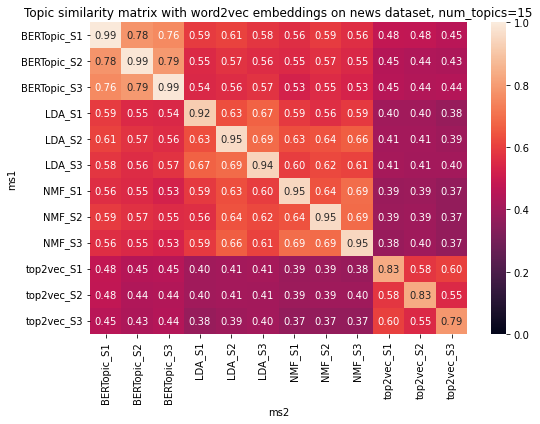

In [6]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")

param_name, param_value = "num_topics", 15

MS_topic_representations, df_similarity_wv_news = topic_model_similarity_matrix(df_news, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

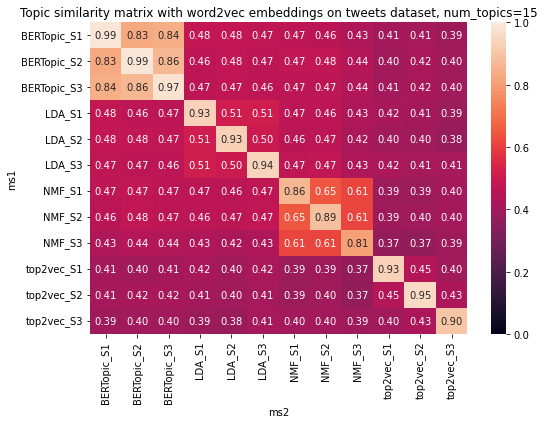

In [11]:
dataset = "tweets"
param_name, param_value = "num_topics", 15

df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
MS_topic_representations, df_similarity_wv_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

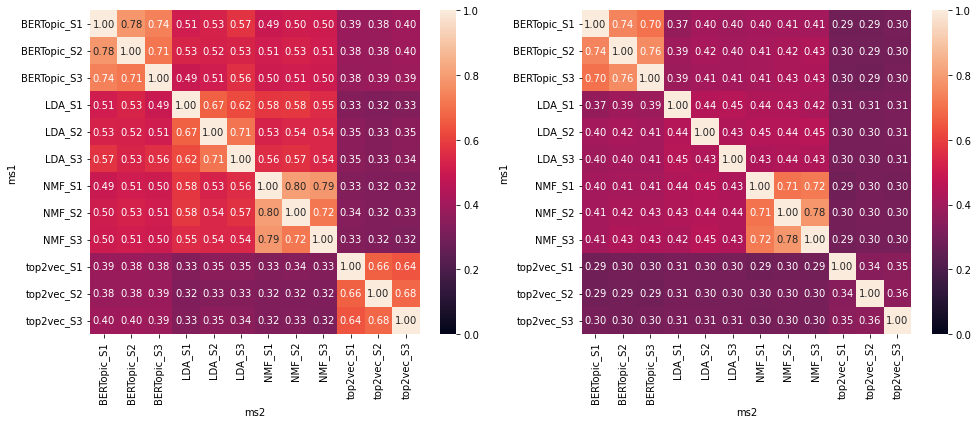

In [55]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with wv embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

#### fasttext similarity

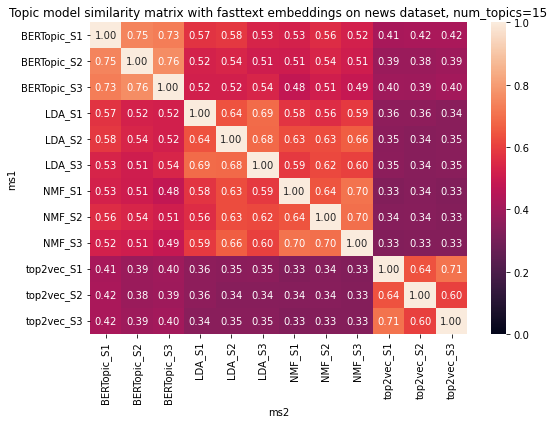

In [7]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")

param_name, param_value = "num_topics", 15
## 2min
MS_topic_representations, df_similarity_ft_news = topic_model_similarity_matrix(df_news, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

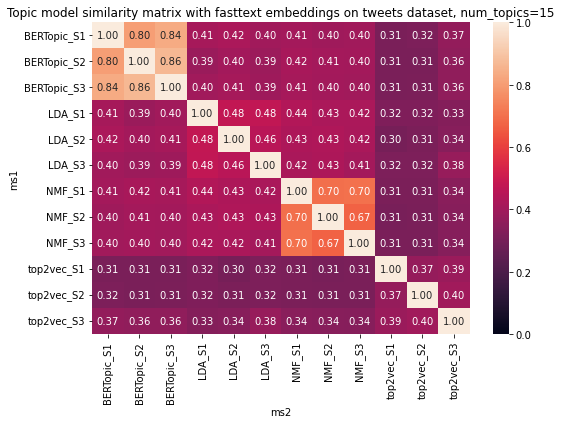

In [8]:
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")

param_name, param_value = "num_topics", 15

MS_topic_representations, df_similarity_ft_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

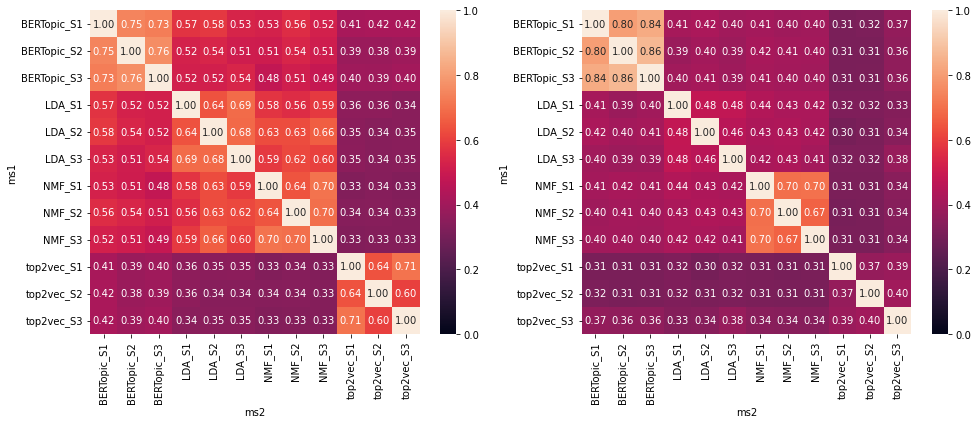

In [58]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with fasttext embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

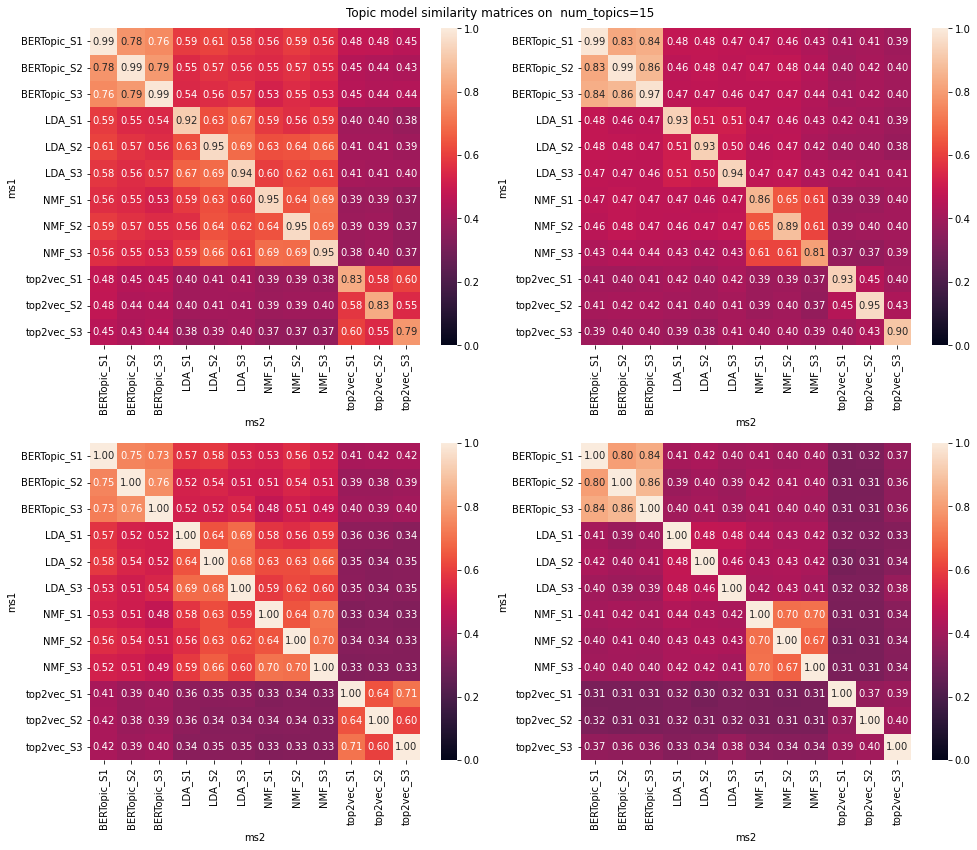

In [12]:
fig, axs = plt.subplots(2,2, figsize=(14, 12))
axs[0][0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][0])
axs[0][1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][1])
axs[1][0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][0])
axs[1][1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][1])

plt.suptitle(f"Topic model similarity matrices on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

### 5 topics parameters

#### wordvec embedding

In [22]:
num_samples = 50000
year = 2020


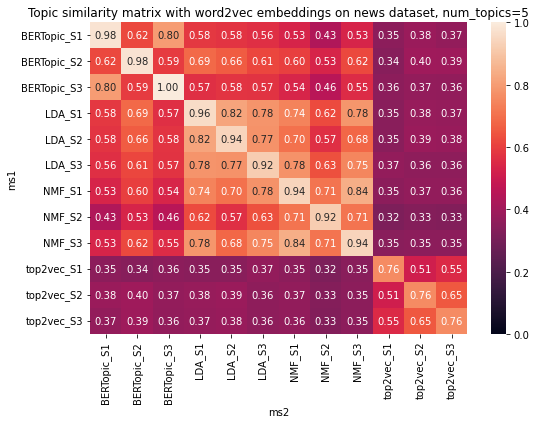

In [23]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
param_name, param_value = "num_topics", 5
MS_topic_representations, df_similarity_wv_news = topic_model_similarity_matrix(df_news, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))

sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

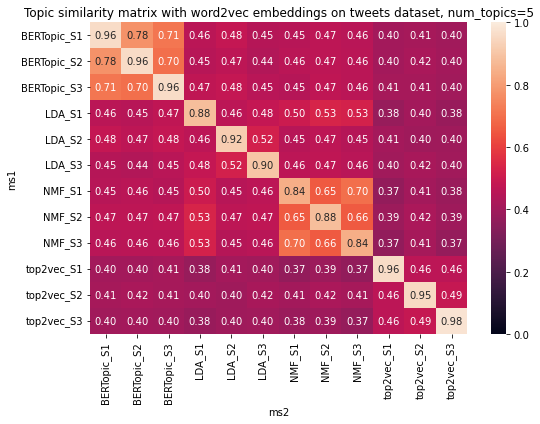

In [24]:
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
MS_topic_representations, df_similarity_wv_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

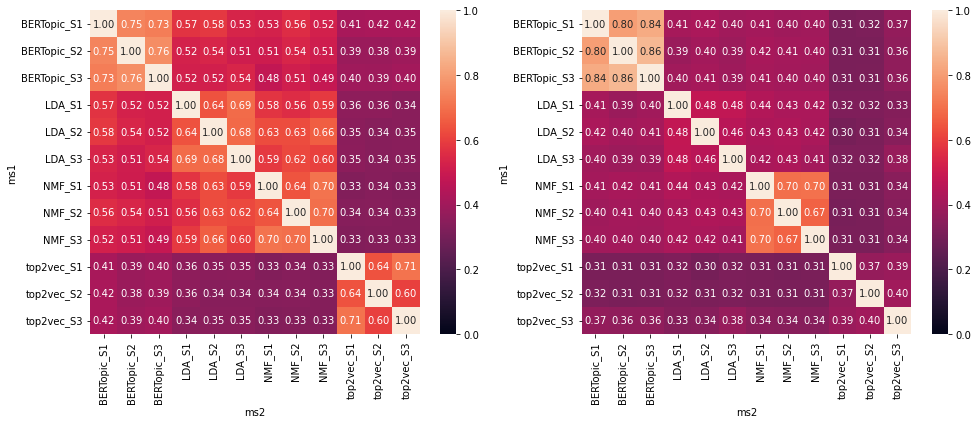

In [63]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with wv embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

#### fasttext similarity

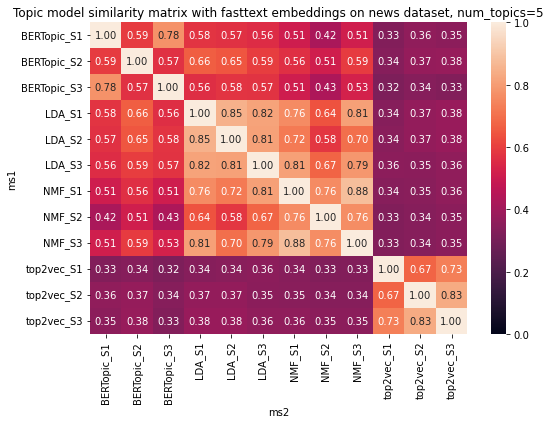

In [25]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")

param_name, param_value = "num_topics", 5
## 2min
MS_topic_representations, df_similarity_ft_news = topic_model_similarity_matrix(df_news, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

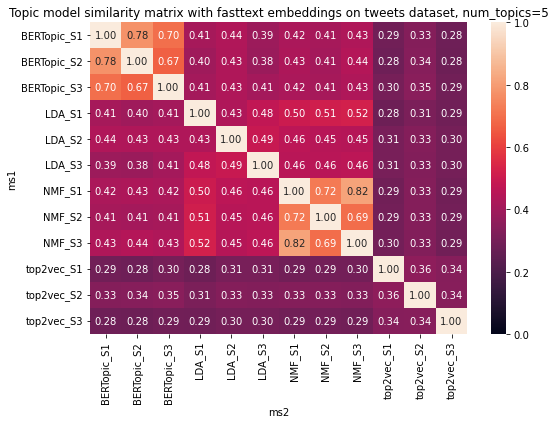

In [26]:
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")

param_name, param_value = "num_topics", 5

MS_topic_representations, df_similarity_ft_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

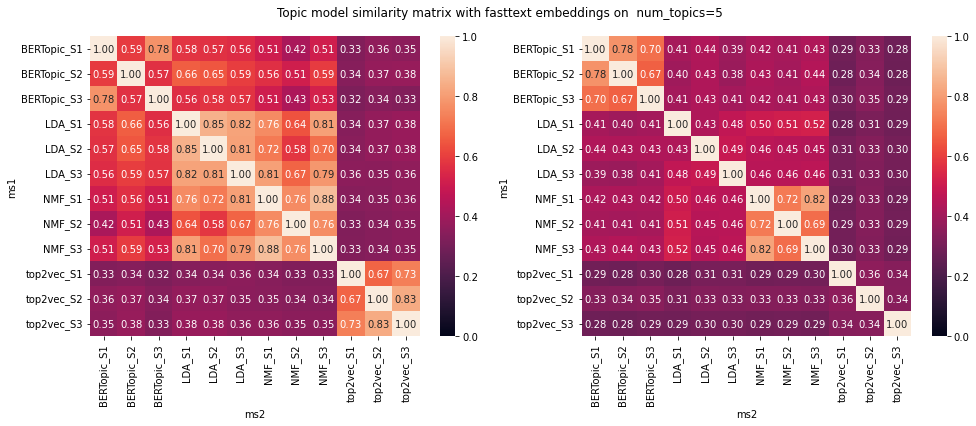

In [27]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with fasttext embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrixft_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

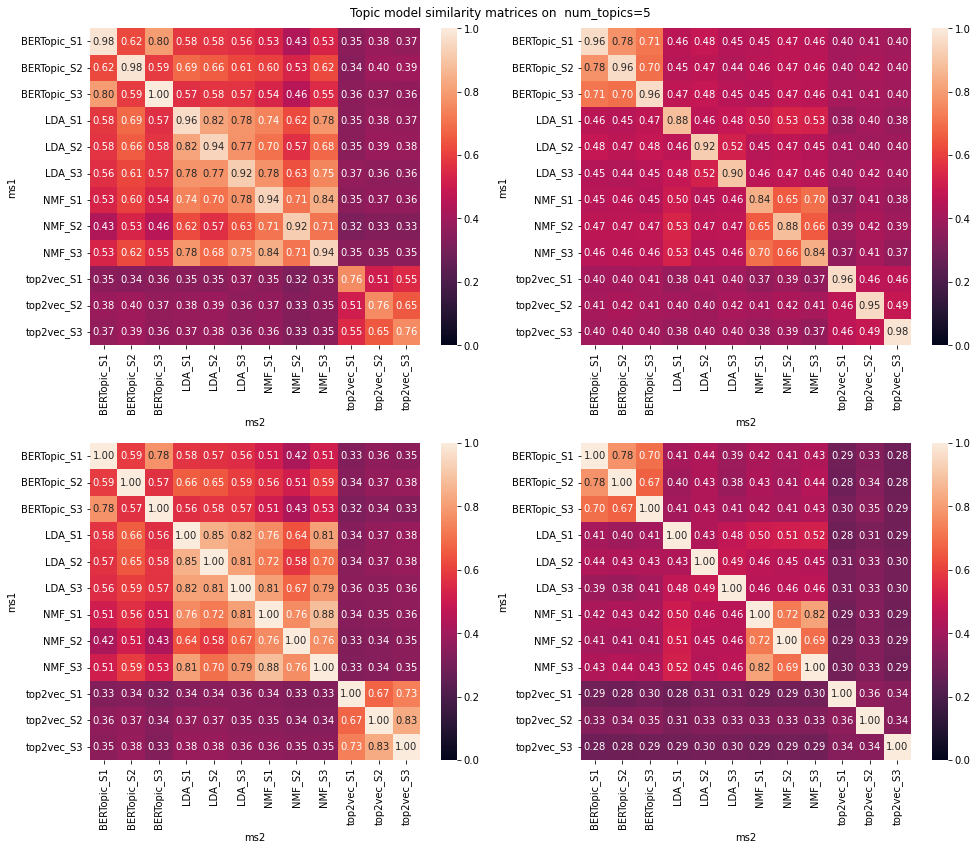

In [28]:
fig, axs = plt.subplots(2,2, figsize=(14, 12))
axs[0][0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][0])
axs[0][1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][1])
axs[1][0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][0])
axs[1][1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][1])

plt.suptitle(f"Topic model similarity matrices on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

### 5 words parameters

#### wordvec embedding

In [37]:
num_samples = 50000
year = 2020


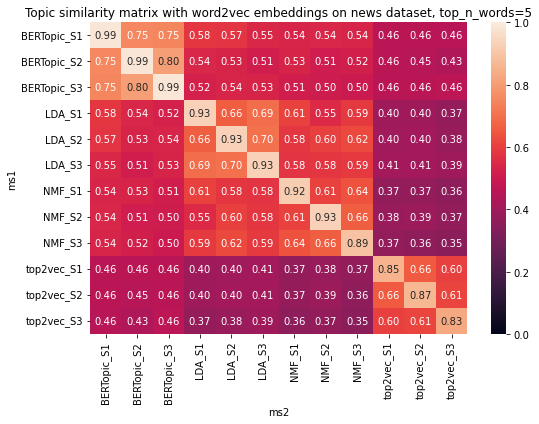

In [38]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/top_n_words_models_{dataset}_{num_samples}_{year}.csv")

param_name, param_value = "top_n_words", 5

MS_topic_representations, df_similarity_wv_news = topic_model_similarity_matrix(df_news, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

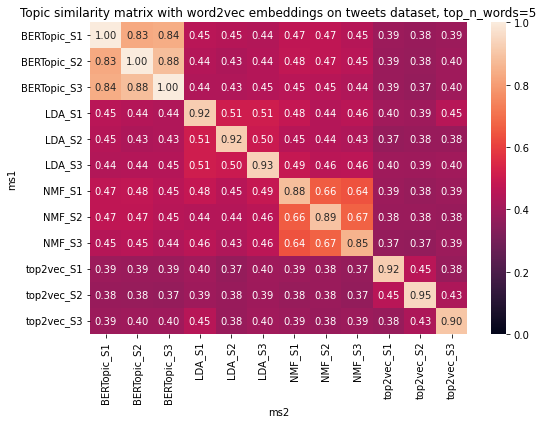

In [39]:
dataset = "tweets"
param_name, param_value = "top_n_words", 5

df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/top_n_words_models_{dataset}_{num_samples}_{year}.csv")
MS_topic_representations, df_similarity_wv_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

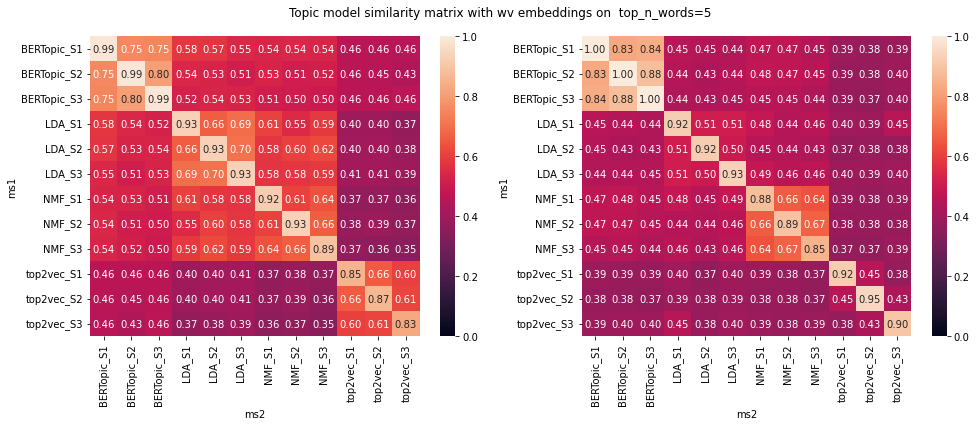

In [40]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with wv embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

#### fasttext similarity

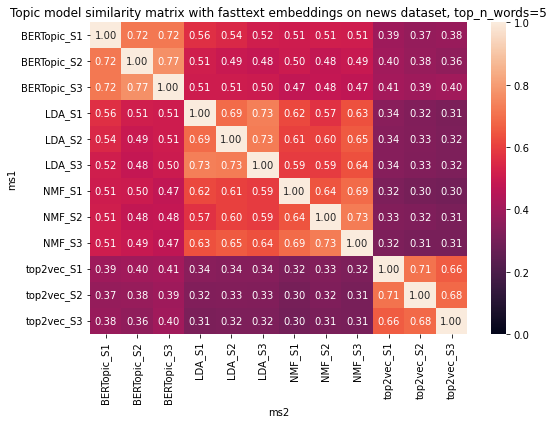

In [41]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/top_n_words_models_{dataset}_{num_samples}_{year}.csv")

param_name, param_value = "top_n_words", 5
## 2min
MS_topic_representations, df_similarity_ft_news = topic_model_similarity_matrix(df_news, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

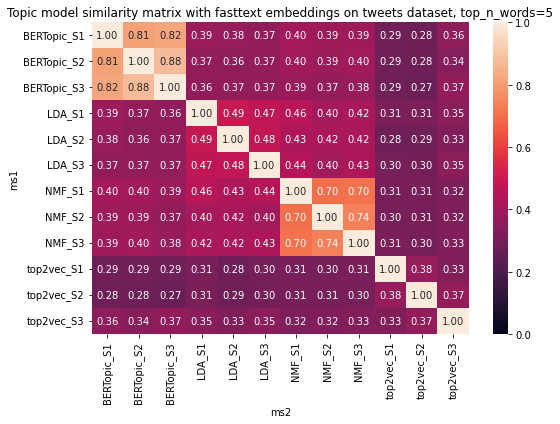

In [42]:
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/top_n_words_models_{dataset}_{num_samples}_{year}.csv")

param_name, param_value = "top_n_words", 5

MS_topic_representations, df_similarity_ft_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

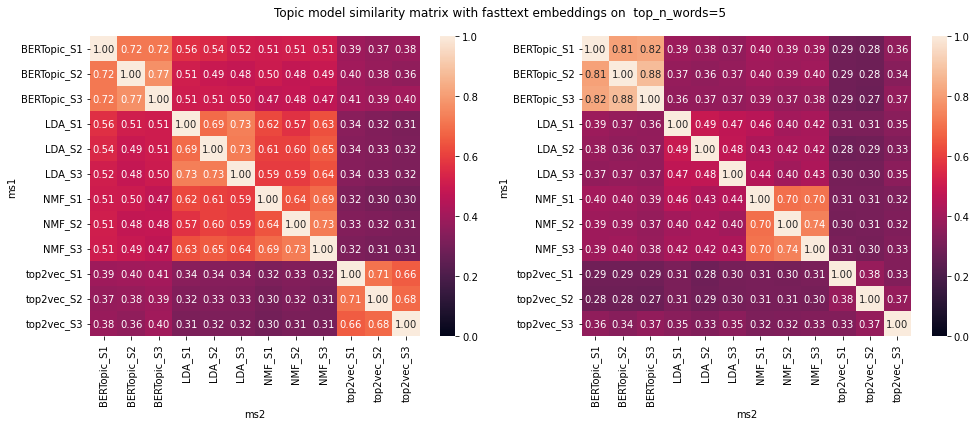

In [43]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with fasttext embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

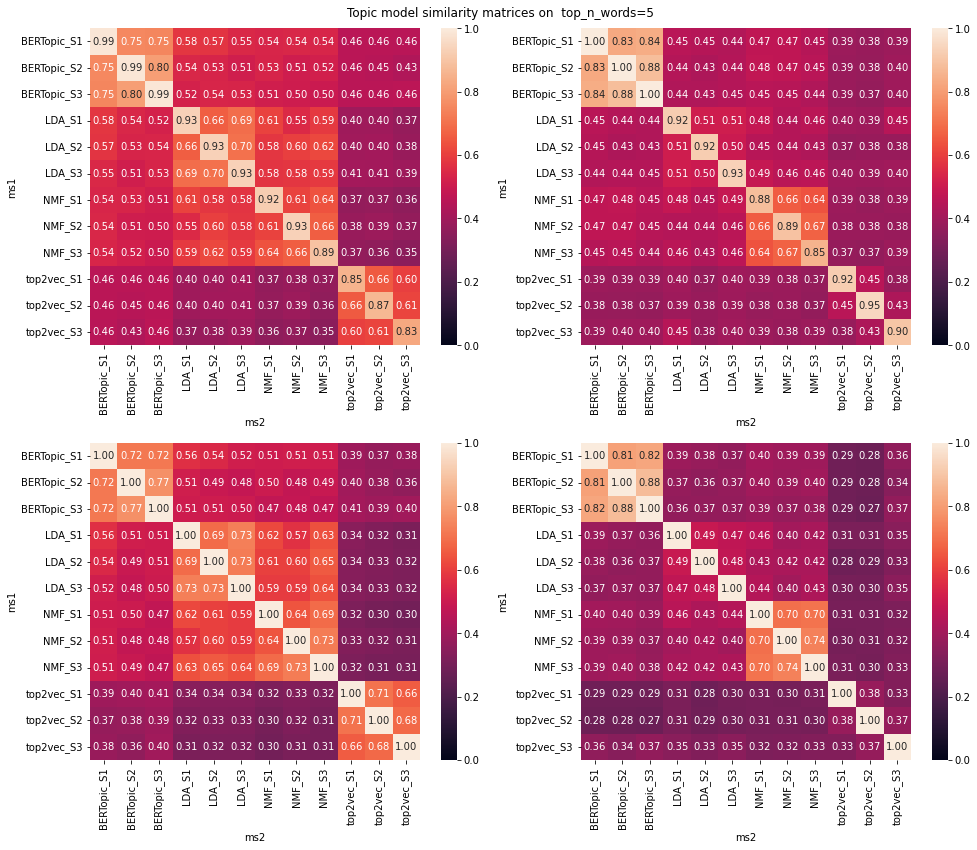

In [44]:
fig, axs = plt.subplots(2,2, figsize=(14, 12))
axs[0][0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][0])
axs[0][1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][1])
axs[1][0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][0])
axs[1][1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][1])

plt.suptitle(f"Topic model similarity matrices on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

### 95k docs

#### wordvec embedding

In [77]:
num_samples = 50000
year = 2020


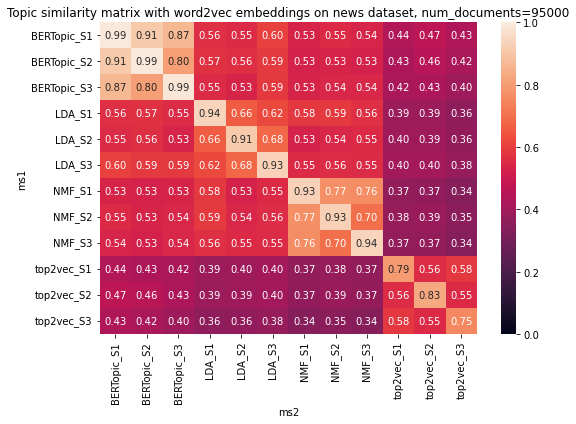

In [45]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_news_300000.csv")

param_name, param_value = "num_documents", 95000

MS_topic_representations, df_similarity_wv_news = topic_model_similarity_matrix(df_news, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))

sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

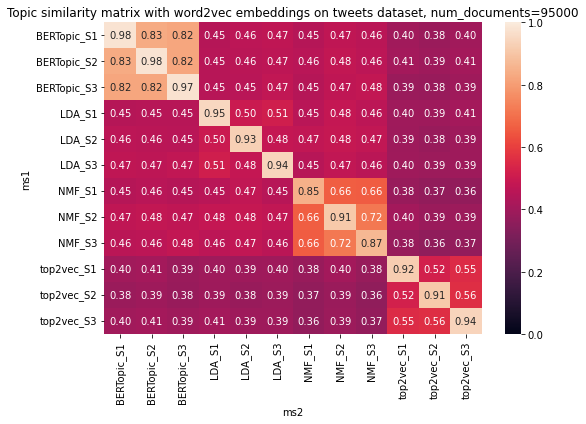

In [46]:
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_tweets_300000.csv")
param_name, param_value = "num_documents", 95000

MS_topic_representations, df_similarity_wv_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with word2vec embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

#### fasttext similarity

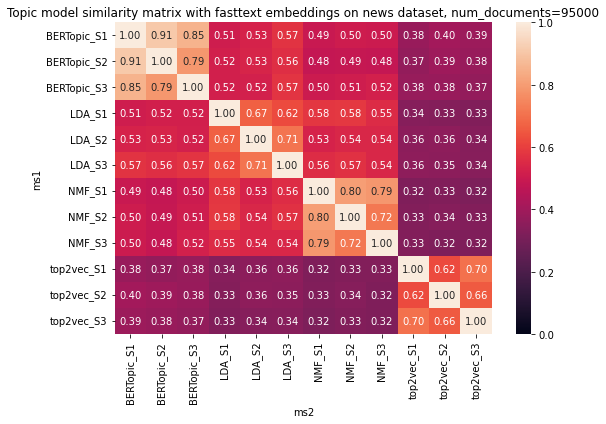

In [48]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_news_300000.csv")

param_name, param_value = "num_documents", 95000
## 2min
MS_topic_representations, df_similarity_ft_news = topic_model_similarity_matrix(df_news, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

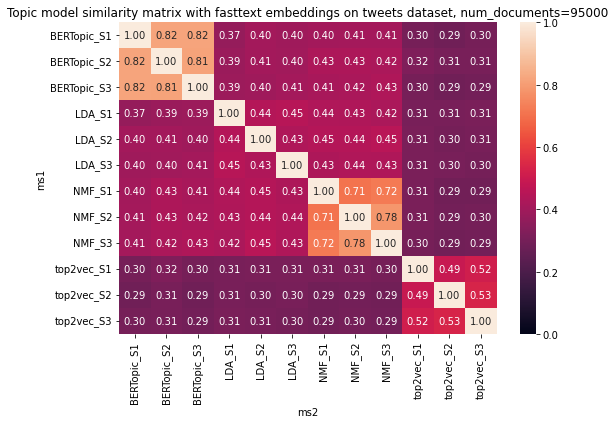

In [49]:
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_tweets_300000.csv")

param_name, param_value = "num_documents", 95000

MS_topic_representations, df_similarity_ft_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
#plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.png")
#pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/{param_name}_eval{suffix}.pickle", 'wb')) 
plt.show()

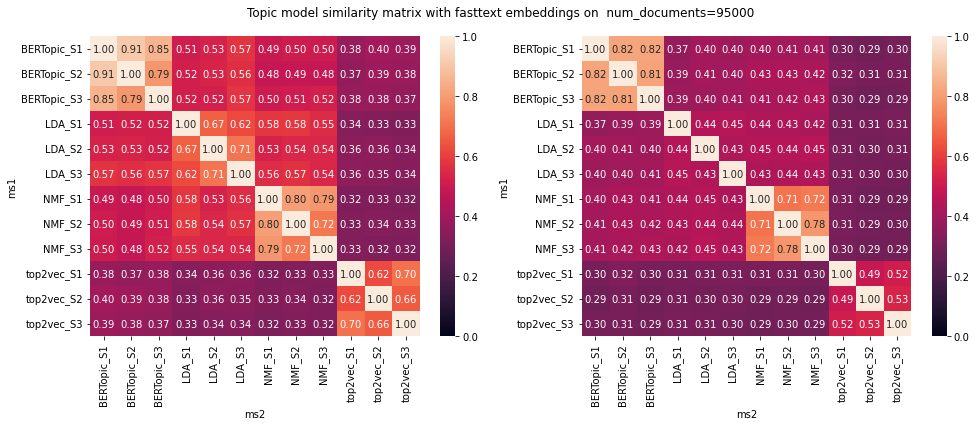

In [50]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with fasttext embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

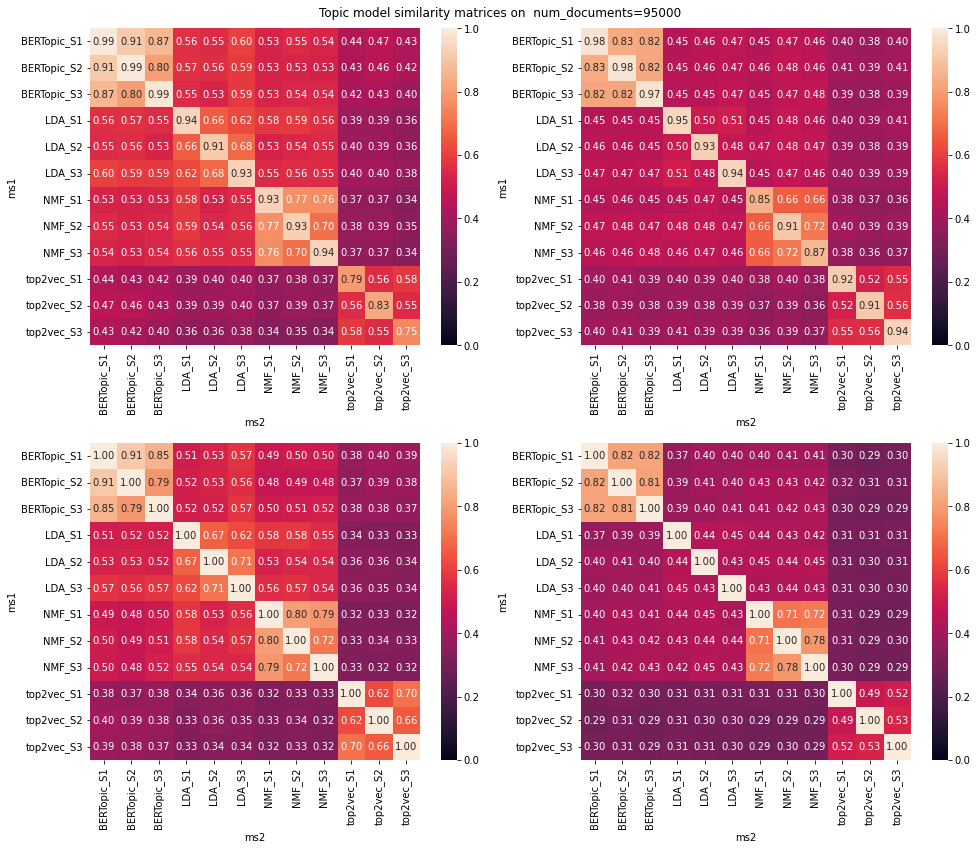

In [51]:
fig, axs = plt.subplots(2,2, figsize=(14, 12))
axs[0][0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][0])
axs[0][1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][1])
axs[1][0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][0])
axs[1][1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][1])

plt.suptitle(f"Topic model similarity matrices on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

### 95k docs sampled

#### wordvec embedding

In [52]:
num_samples = 50000
year = 2020


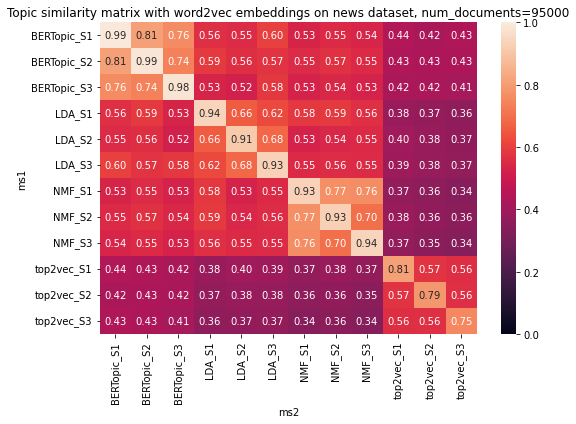

In [53]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_news_300000_sampled_docs.csv")

param_name, param_value = "num_documents", 95000

MS_topic_representations, df_similarity_wv_news = topic_model_similarity_matrix(df_news, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))

sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{dataset}_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{dataset}_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

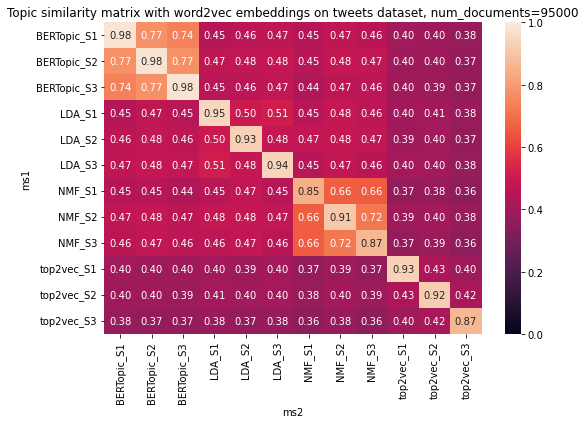

In [54]:
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_tweets_300000_sampled_docs.csv")
param_name, param_value = "num_documents", 95000

MS_topic_representations, df_similarity_wv_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic similarity matrix with word2vec embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{dataset}_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{dataset}_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

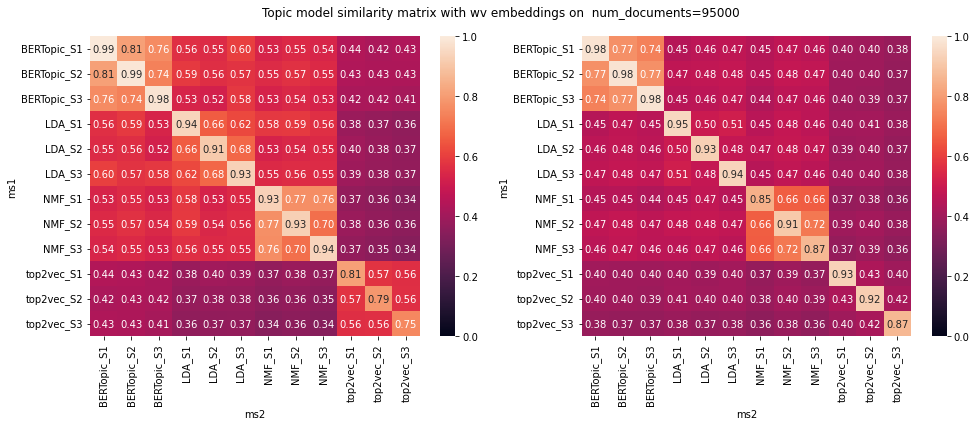

In [55]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with wv embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_wv_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

#### fasttext similarity

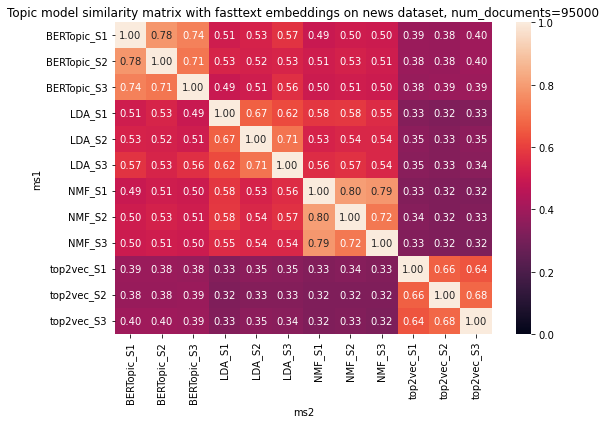

In [56]:
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_news_300000_sampled_docs.csv")

param_name, param_value = "num_documents", 95000
## 2min
MS_topic_representations, df_similarity_ft_news = topic_model_similarity_matrix(df_news, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{dataset}_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{dataset}_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

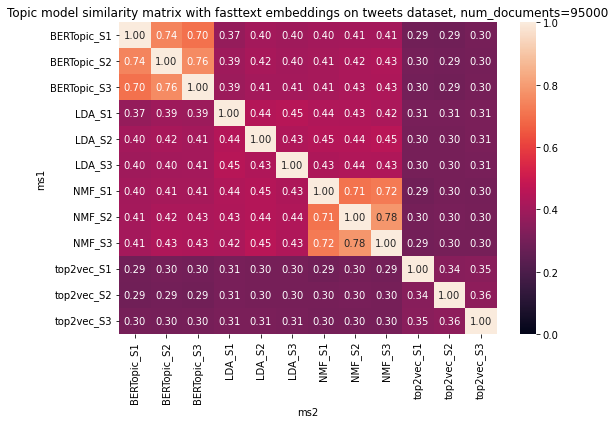

In [57]:
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_documents_models_tweets_300000_sampled_docs.csv")

param_name, param_value = "num_documents", 95000

MS_topic_representations, df_similarity_ft_tweets = topic_model_similarity_matrix(df_tweets, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)
fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on {dataset} dataset, {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{dataset}_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{dataset}_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

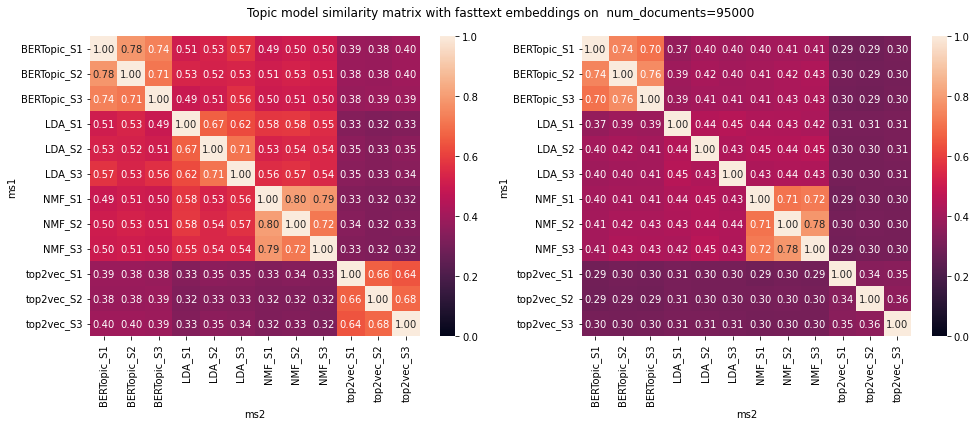

In [58]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])

plt.suptitle(f"Topic model similarity matrix with fasttext embeddings on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

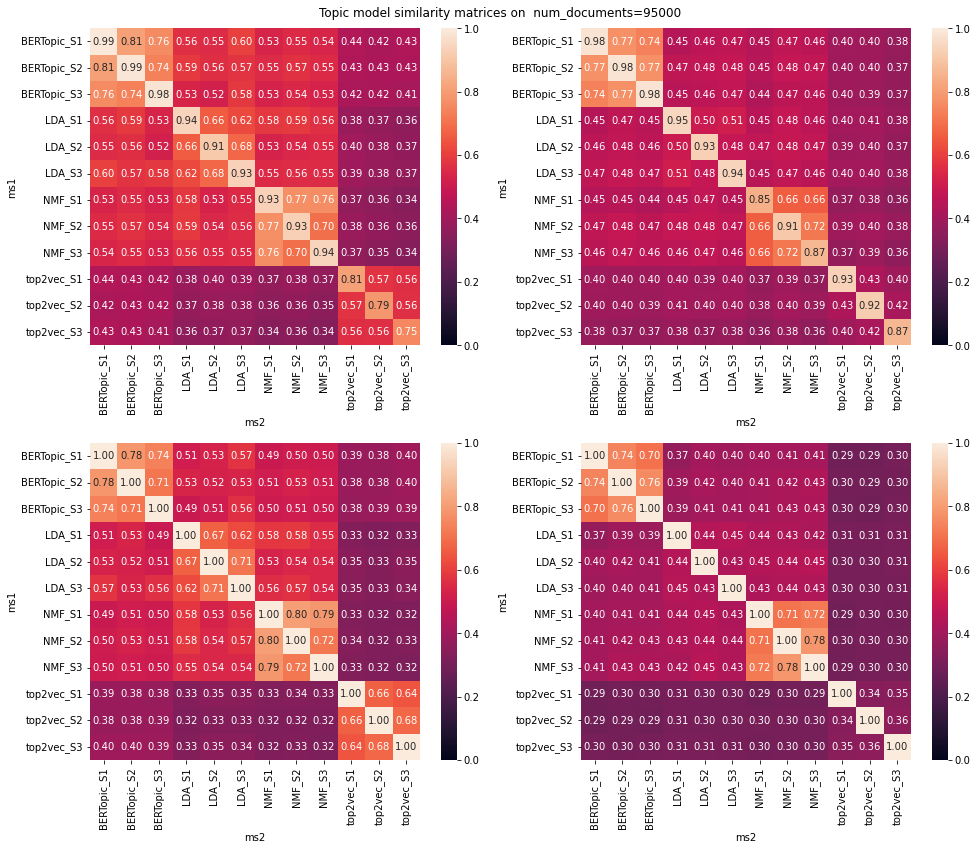

In [59]:
fig, axs = plt.subplots(2,2, figsize=(14, 12))
axs[0][0] = sns.heatmap(df_similarity_wv_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][0])
axs[0][1] = sns.heatmap(df_similarity_wv_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0][1])
axs[1][0] = sns.heatmap(df_similarity_ft_news, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][0])
axs[1][1] = sns.heatmap(df_similarity_ft_tweets, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1][1])

plt.suptitle(f"Topic model similarity matrices on  {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}_sampled.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_{param_value}_{param_name}_sampled.pickle", 'wb')) 
plt.show()

## cross corpus topic similarities

In [2]:



def cross_corpus_topic_model_similarity_matrix(df1, df2, param_name, param_value, metric_name, embedding_function, fasttext_model = None, word2vec_model=None, sloberta_model=None, sloberta_tokenizer=None, verbose=False):
    MS_topic_representations1 = {}
    for model_name in ["BERTopic", "top2vec", "LDA", "NMF", ]:
        for seed in [1,2,3]:
            topics = get_models_topic_words(df1, model_name=model_name, param_name=param_name, param_value=param_value, seed=seed, verbose=False)
            MS_topic_representations1[f"{model_name}_S{seed}"] = topics

    MS_topic_representations2 = {}
    for model_name in ["BERTopic", "top2vec", "LDA", "NMF", ]:
        for seed in [1,2,3]:
            topics = get_models_topic_words(df2, model_name=model_name, param_name=param_name, param_value=param_value, seed=seed, verbose=False)
            MS_topic_representations2[f"{model_name}_S{seed}"] = topics

    dict_similarity = {"ms1":[], "ms2":[], "score":[]}
    # takes 1min
    for ms1, topics1 in MS_topic_representations1.items():
        for ms2, topics2 in MS_topic_representations2.items():
            if metric_name ==  "word2vec":
                matching, score = get_maximum_topic_matching(topics1, topics2, metric_name="word2vec", embedding_function=embedding_function, word2vec_model=word2vec_model, verbose=False)
            if metric_name ==  "fasttext":
                matching, score = get_maximum_topic_matching(topics1, topics2, metric_name="fasttext", embedding_function=embedding_function, fasttext_model=fasttext_model, verbose=False)
            
            dict_similarity["ms1"].append(ms1)
            dict_similarity["ms2"].append(ms2)
            dict_similarity["score"].append(score)

    df_similarity = pd.DataFrame(dict_similarity)
    df_similarity = df_similarity.pivot(index="ms1", columns="ms2", values="score")
    return MS_topic_representations1, MS_topic_representations2, df_similarity


    

### word2vec

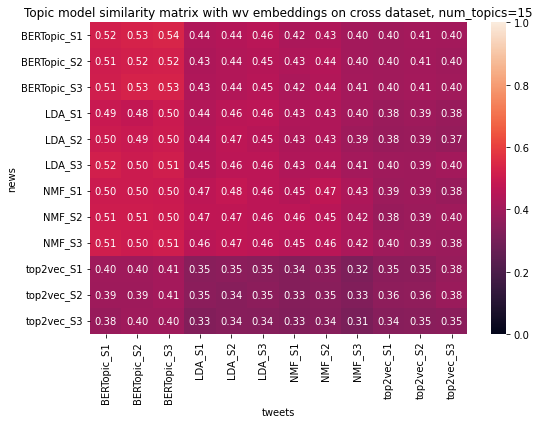

In [13]:
num_samples=50000
year=2020
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")


param_name, param_value = "num_topics", 15
## 2min
MS_topic_representations, MS_topic_representations2, df_similarity_wv = cross_corpus_topic_model_similarity_matrix(df_news, df_tweets, param_name, param_value, "word2vec", embedding_function=get_word2vec_embedding, word2vec_model=word2vec_model, verbose=False)

fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_wv, annot=True, fmt=".2f",vmin=0, vmax=1)
plt.xlabel("tweets")
plt.ylabel("news")
plt.title(f"Topic model similarity matrix with wv embeddings on cross dataset, {param_name}={param_value}")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_cross_wv_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_cross_wv_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

### fasttext

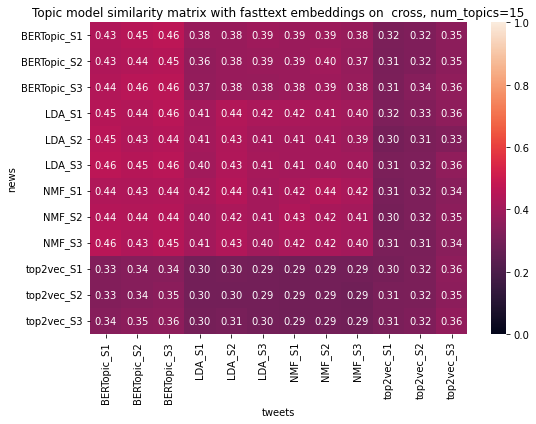

In [12]:
num_samples=50000
year=2020
dataset = "news"
df_news = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")
dataset = "tweets"
df_tweets = pd.read_csv(f"{ROOT_PATH}masters-thesis/results/num_topics_models_{dataset}_{num_samples}_{year}.csv")


param_name, param_value = "num_topics", 15
## 2min
MS_topic_representations, MS_topic_representations2, df_similarity_cross_ft = cross_corpus_topic_model_similarity_matrix(df_news, df_tweets, param_name, param_value, "fasttext", embedding_function=get_fasttext_embedding, fasttext_model=ft, verbose=False)


fig, axs = plt.subplots( figsize=(8, 6))
sns.heatmap(df_similarity_cross_ft, annot=True, fmt=".2f",vmin=0, vmax=1)

plt.title(f"Topic model similarity matrix with fasttext embeddings on  cross, {param_name}={param_value}")
plt.xlabel("tweets")
plt.ylabel("news")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_cross_{param_value}_{param_name}.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_ft_cross_{param_value}_{param_name}.pickle", 'wb')) 
plt.show()

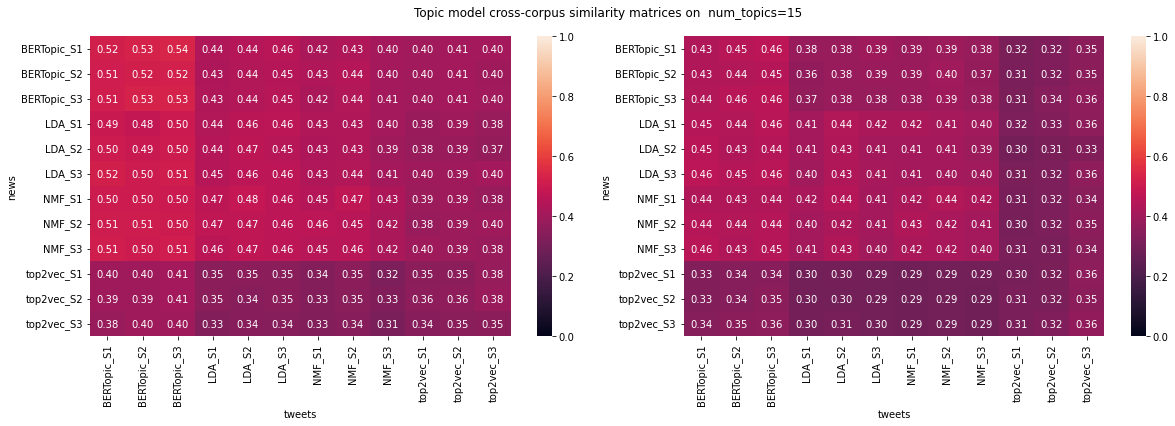

In [19]:
fig, axs = plt.subplots(1,2, figsize=(17, 6))
axs[0] = sns.heatmap(df_similarity_wv, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[0])
axs[1] = sns.heatmap(df_similarity_cross_ft, annot=True, fmt=".2f",vmin=0, vmax=1, ax=axs[1])


plt.suptitle(f"Topic model cross-corpus similarity matrices on  {param_name}={param_value}")
axs[0].set_xlabel("tweets")
axs[0].set_ylabel("news")
axs[1].set_xlabel("tweets")
axs[1].set_ylabel("news")
plt.tight_layout()
plt.savefig(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_cross_corpus_{param_value}_{param_name}_sampled.png")
pickle.dump(fig, open(f"{ROOT_PATH}masters-thesis/results/plots/sim_matrix_cross_corpus_{param_value}_{param_name}_sampled.pickle", 'wb')) 
plt.show()